## Análisis de datos de Mercadolibre

Los inmuebles que nos llegan tienen un formato particular. Tenemos información general en el cuerpo y varios atributos en un campo llamado "attributes" en formato de lista.

En cuanto a los campos generales que no se encuentran embebidos, tenemos los siguientes:

- title: Título de la publicación

- permalink: Link a la publicación
- currency_id: Puede ser "USD" o "ARS"
- price: Precio de la propiedad

Cada propiedad tiene el campo "location" que contiene información de la ubicación, se tienen los siguientes atributos:

- address_line: La dirección en formato texto

- latitude
- longitude
- neighborhood: Es un json que, dentro de "name" tiene el nombre del barrio. Hay algunas diferencias con Cabaprop, por lo que vamos a convertir algunos barrios en otros para normalizar la información
- city: Contiene el nombre de la ciudad, aca utilizaremos "Capital Federal"
- state: Contiene el nombre del estado, aca utilizaremos "Capital Federal"
- country: Contiene el país, aca utilizaremos Argentina

Cada propiedad tiene una lista en el campo "attributes", el cual contiene valores para ciertas características del inmueble, por ejemplo, sus metros cuadrados, baños, etc etc. Cada uno con su ID.

Dentro de los atributos encontramos los siguientes (Por ahora):

- HAS_TELEPHONE_LINE: Tiene valores "Si" y "No", igual es un campo que no lo vamos a utilizar

- HAS_AIR_CONDITIONING: Tiene valores "Si" y "No", igual es un campo que no lo vamos a utilizar
- BEDROOMS: Contiene la cantidad de dormitorios de la propiedad, es un valor numérico
- COVERED_AREA: Contiene área cubierta y su unidad. Esto se encuentra, dentro del atributo en un campo struct con la siguiente pinta `{'number': 200, 'unit': 'm²'}`
- FULL_BATHROOMS: Cantidad de baños de la propiedad, en valor numérico
- ROOMS: Cantidad de cuartos que tiene la propiedad, valor numérico. Vamos a tener que analizar aquí su comparación con Bedrooms y Bathrooms
- TOTAL_AREA: Misma idea que COVERED_AREA, mismos struct
- OPERATION: En sus valores tiene la operacion. Aquí puede ser "Alquiler", "Alquiler Temporal" y "Venta"
- PROPERTY_TYPE: En sus valores tiene el tipo de propiedad. Aquí puede ser "Casa", "Oficina", "PH" y "Departamento"
- ITEM_CONDITION: En sus valores tiene "Usado" y "Nuevo"
- WITH_VIRTUAL_TOUR: Tour virtual, no nos importa
- OFFICES: No se entiende que es, de todas formas no nos importa

In [84]:
# Obtenemos las variables de entorno

import os
from dotenv import load_dotenv

PATH = os.getcwd()
PATH = PATH.replace("/Price/Exploration", "")

load_dotenv(PATH + "/.env")


True

In [85]:
import pymongo
import urllib.parse
import certifi
from pymongo.mongo_client import MongoClient
import json
import pandas as pd
import requests
import random

pd.set_option('display.max_columns', None)

username = urllib.parse.quote_plus(os.getenv("MONGO_USERNAME"))
password = urllib.parse.quote_plus(os.getenv("MONGO_PASSWORD"))

uri = "mongodb://{}:{}@{}:{}/?authSource={}&authMechanism={}".format(username, password, os.getenv("MONGO_HOST"),
                                            os.getenv("MONGO_PORT"), os.getenv("MONGO_DATABASE"), "SCRAM-SHA-1")

client = MongoClient(uri)

In [86]:
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [87]:
db = client[os.getenv("MONGO_DATABASE")]

In [88]:
meli_collection = db.MeliStaging

# Debido a que el tipo de operación esta embebido en el campo "attributes" vamos a tener
# que importar todo y filtrar luego

properties = meli_collection.find({})

In [89]:
test = meli_collection.find_one({})
print(test)

{'_id': ObjectId('64f00b6321e7525ff3158fb3'), 'id': 'MLA1384827101', 'title': 'Belgrano   Moldes 1400  Casa  5 Ambientes  Jardín', 'condition': 'used', 'thumbnail_id': '654855-MLA71285932152_082023', 'catalog_product_id': None, 'listing_type_id': 'gold_premium', 'permalink': 'https://casa.mercadolibre.com.ar/MLA-1384827101-belgrano-moldes-1400-casa-5-ambientes-jardin-_JM', 'buying_mode': 'classified', 'site_id': 'MLA', 'category_id': 'MLA1467', 'domain_id': 'MLA-HOUSES_FOR_RENT', 'thumbnail': 'http://http2.mlstatic.com/D_654855-MLA71285932152_082023-I.jpg', 'currency_id': 'USD', 'order_backend': 7, 'price': 2000, 'original_price': None, 'sale_price': None, 'sold_quantity': 0, 'available_quantity': 1, 'official_store_id': 51270, 'official_store_name': 'David Cipolla Propiedades', 'use_thumbnail_id': True, 'accepts_mercadopago': False, 'tags': [], 'shipping': {'store_pick_up': False, 'free_shipping': False, 'logistic_type': None, 'mode': 'not_specified', 'tags': [], 'benefits': None, 'pr

In [90]:
properties_list = list()

for p in properties:
    properties_list.append(p)

## Porción de análisis general de los campos

In [91]:
properties_df = pd.DataFrame(properties_list)
properties_df

,_id,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,domain_id,thumbnail,currency_id,order_backend,price,original_price,sale_price,sold_quantity,available_quantity,official_store_id,official_store_name,use_thumbnail_id,accepts_mercadopago,tags,shipping,stop_time,seller,seller_address,address,attributes,location,seller_contact,installments,winner_item_id,catalog_listing,discounts,promotions,inventory_id
0,64f00b6321e7525ff3158fb3,MLA1384827101,Belgrano Moldes 1400 Casa 5 Ambientes Jardín,used,654855-MLA71285932152_082023,None,gold_premium,https://casa.mercadolibre.com.ar/MLA-138482710...,classified,MLA,MLA1467,MLA-HOUSES_FOR_RENT,http://http2.mlstatic.com/D_654855-MLA71285932...,USD,7,2000.0,None,None,0,1,51270.0,David Cipolla Propiedades,True,False,[],"{'store_pick_up': False, 'free_shipping': Fals...",2023-11-26T04:00:00.000Z,"{'id': 248239683, 'nickname': 'DAVIDCIPOLLAPRO...","{'comment': '', 'address_line': '', 'id': None...","{'state_id': 'TUxBUENBUGw3M2E1', 'state_name':...","[{'id': 'HAS_TELEPHONE_LINE', 'name': 'Línea t...","{'address_line': 'Moldes 1400', 'zip_code': '...","{'contact': 'Belgrano', 'other_info': '', 'web...",None,None,False,None,[],None
1,64f00b6321e7525ff3158fb4,MLA1385227583,"Alquilo Oficina En Callao Y Corrientes, A Fren...",used,680828-MLA71331385272_082023,None,gold_premium,https://inmueble.mercadolibre.com.ar/MLA-13852...,classified,MLA,MLA50539,MLA-OFFICES_FOR_RENT,http://http2.mlstatic.com/D_680828-MLA71331385...,ARS,1,150000.0,None,None,0,1,54484.0,Insaurralde Brokers,True,False,[],"{'store_pick_up': False, 'free_shipping': Fals...",2024-08-27T04:00:00.000Z,"{'id': 757249251, 'nickname': 'INSAURRALDEBROK...","{'comment': '', 'address_line': '', 'id': None...","{'state_id': 'TUxBUENBUGw3M2E1', 'state_name':...","[{'id': 'COVERED_AREA', 'name': 'Superficie cu...","{'address_line': 'Callao 400', 'zip_code': '',...",{'contact': 'INSAURRALDE Brks. INSAURRALDE Brk...,None,None,False,None,[],None
2,64f00b6321e7525ff3158fb5,MLA1481902544,Ph Dúplex Tza Común Sin Exp Precio Con Serv L...,not_specified,862599-MLA70220443191_062023,None,gold_premium,https://inmueble.mercadolibre.com.ar/MLA-14819...,classified,MLA,MLA105181,MLA-HORIZONTAL_PROPERTY_FOR_RENT,http://http2.mlstatic.com/D_862599-MLA70220443...,ARS,2,180000.0,None,None,0,1,NaN,NaN,True,False,"[dragged_visits, free_relist]","{'store_pick_up': False, 'free_shipping': Fals...",2023-09-23T04:00:00.000Z,"{'id': 112639730, 'nickname': 'ALIADO2105', 'c...","{'comment': '', 'address_line': '', 'id': None...","{'state_id': 'TUxBUENBUGw3M2E1', 'state_name':...","[{'id': 'BEDROOMS', 'name': 'Dormitorios', 'va...","{'address_line': 'Cevallos 600', 'zip_code': '...","{'contact': '', 'other_info': '', 'webpage': '...",None,None,False,None,[],None
3,64f00b6321e7525ff3158fb6,MLA1482483178,Moderno Departamento De Dos Ambientes En Alqui...,used,890268-MLA71309175549_082023,None,gold_premium,https://departamento.mercadolibre.com.ar/MLA-1...,classified,MLA,MLA50279,MLA-APARTMENTS_FOR_VACATION_RENTAL,http://http2.mlstatic.com/D_890268-MLA71309175...,USD,19,800.0,None,None,0,1,NaN,NaN,True,False,[],"{'store_pick_up': False, 'free_shipping': Fals...",2024-08-23T04:00:00.000Z,"{'id': 373191144, 'nickname': 'MAPROINMUEBLES'...","{'comment': '', 'address_line': '', 'id': None...","{'state_id': 'TUxBUENBUGw3M2E1', 'state_name':...","[{'id': 'HAS_TELEPHONE_LINE', 'name': 'Línea t...","{'address_line': 'Arcos al 1900', 'zip_code': ...","{'contact': 'Mapro Inmuebles', 'other_info': '...",None,None,False,None,[],None
4,64f00b6321e7525ff3158fb7,MLA1385452301,Alquiler Temporal - Departamento A Estrenar En...,new,935501-MLA71347802488_082023,None,gold_premium,https://casa.mercadolibre.com.ar/MLA-138545230...,classified,MLA,MLA50278,MLA-HOUSES_FOR_VACATION_RENTAL,http://http2.mlstatic.com/D_935501-MLA71347802...,USD,1,600.0,None,None,0,1,NaN,NaN,True,False,[],"{'store_pick_up': False, 'free_shipping': Fals...",2024-08-28

## Porción Análisis de Location

In [92]:
location_list = list()

for p in properties_list:
    location_list.append(p["location"])

location_df = pd.DataFrame(location_list)

In [93]:
neighborhood_list = list()
city_list = list()
state_list = list()
coutry_list = list()

for index, row in location_df.iterrows():
    neighborhood_list.append(row["neighborhood"])
    city_list.append(row["city"])
    state_list.append(row["state"])
    coutry_list.append(row["country"])

In [94]:
neighborhood_df = pd.DataFrame(neighborhood_list)

# Vamos a extraer los barrios ya que deberían coincidir con los de cabaprop
barrios_meli_list = neighborhood_df.name.unique().tolist()

with open("../Utils/barrios.json") as json_file:
    barrios = json.load(json_file)

barrios_cabaprop_list = list(barrios.values())

diff = list(set(barrios_meli_list).difference(barrios_cabaprop_list))
diff

['Santa Rita',
 'Botánico',
 'Paternal',
 'Puerto Retiro',
 'Las Cañitas',
 'BARRIO RIVER',
 'Palermo Nuevo',
 'Belgrano Chico',
 'Villa Gral. Mitre',
 'CABALLITO',
 nan,
 'La Boca',
 'Nueva Pompeya']

Vamos a mappear de la siguiente forma

Botánico -> Palermo Botanico  
Villa Gral. Mitre -> Villa General Mitre  
Santa Rita -> Villa Santa Rita  
CABALLITO -> Caballito  
Belgrano Chico -> Belgrano C  
Paternal -> La paternal  
Palermo Nuevo -> Palermo Pacifico  
Nueva Pompeya -> Pompeya  
BARRIO RIVER -> Núñez River  
Las Cañitas -> Palermo Las Cañitas  
La Boca -> La boca  
Puerto Retiro -> Retiro  

In [95]:
state_df = pd.DataFrame(state_list)

# Vamos a extraer los estados ya que deberían coincidir con los de cabaprop
state_meli_list = state_df.name.unique().tolist()
state_meli_list

['Capital Federal']

In [96]:
city_df = pd.DataFrame(city_list)

# Vamos a extraer los barrios ya que deberían coincidir con los de cabaprop
city_meli_list = city_df.name.unique().tolist()
city_meli_list

['Capital Federal', 'Velez Sarsfield', 'Las Cañitas', 'Versailles']

In [97]:
country_df = pd.DataFrame(coutry_list)

# Vamos a extraer los barrios ya que deberían coincidir con los de cabaprop
country_meli_list = country_df.name.unique().tolist()
country_meli_list

['Argentina']

## Porción de análisis de atributos

Modificar el nombre del atributo para obtener un Dataframe que permita analizar sus valores

In [98]:
# Veamos que tiene, en general, attributes en el cursor
attributes_list = list()

for p in properties_list:
    attributes_list.append(p["attributes"])

In [99]:
# Aplanamos la lista para tener todos los atributos de todas las propiedades y ver que tenemos

flat_attributes_list = [item for sublist in attributes_list for item in sublist]

attributes_df = pd.DataFrame(flat_attributes_list)

In [100]:
attribute_df = attributes_df.loc[attributes_df.id == "OPERATION"]

attribute_values = list()

for index, row in attribute_df.iterrows():
    attribute_values.append(row["values"])

In [101]:
flat_attribute_values = [item for sublist in attribute_values for item in sublist]

test_df = pd.DataFrame(flat_attribute_values)
test_df
#print(test_df.name.unique().tolist())

,id,name,struct,source
0,242073,Alquiler,None,1
1,242073,Alquiler,None,1
2,242073,Alquiler,None,1
3,242074,Alquiler temporal,None,1
4,242074,Alquiler temporal,None,1
...,...,...,...,...
12707,242073,Alquiler,None,1
12708,242073,Alquiler,None,1
12709,242074,Alquiler temporal,None,1
12710,242074,Alquiler temporal,None,1


## Normalizacion

Vamos a buscar generar un dataframe idéntico al que obtenemos desde cabaprop. Muchos campos serán vacíos, pero de a poco, mientras
vayamos viendo más atributos, vamos a poder ir agregando información

In [102]:
processed_properties = list()

for index, row in properties_df.iterrows():
    
    # No tenemos info de características y/o amenities en MELI por ahora. Serán todas Falso (0)
    # por ahora

    balcony, yard, rooftop, garage, amoblado, cancha_paddle, cancha_tennis, gimnasio, hidromasaje, laundry = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    microcine, parrilla, piscina, sala_de_juegos, sauna, solarium, spa, sum, garage_visitas = 0, 0, 0, 0, 0, 0, 0, 0, 0

    # No se encuentra description en el objeto de Mercadolibre, aunque en el sitio existe
    description = ""

    # No hacemos manejo de ubicacion por ahora
    centros_comerciales_cercanos, escuelas_cercanas, parques_cercanos = 0, 0, 0

    title = row["title"]

    # Manejo de Precio dolar
    if row["currency_id"] == "USD":
        price = int(row["price"])
    else:
        res = requests.get("https://dolarapi.com/v1/dolares")
        valor_blue_compra = res.json()[1]["compra"]
        price = int(row["price"]) / int(valor_blue_compra)

    # Manejo de Attributes, muchos ifs :(
    # Inicializamos primero las variables para luego filtrar en caso de
    # que no se encuentre info

    antiquity = None
    ambience, bedrooms, bathrooms = None, None, None
    surface_covered, surface_total = 0, 0
    neighborhood = None

    # Aqui encontraremos los "filtros" de tipo de propiedad y operacion
    # Vamos a guardar si debemos o no hacer un skip del agregado a la lista final
    # en una variable
    skip_row = None

    for attribute in row["attributes"]:
        skip_row = False
        if attribute["id"] == "BEDROOMS":
            bedrooms = int(attribute["value_name"])
        elif attribute["id"] == "FULL_BATHROOMS":
            bathrooms = int(attribute["value_name"])
        elif attribute["id"] == "ROOMS":
            ambience = int(attribute["value_name"])
        elif attribute["id"] == "TOTAL_AREA":
            try:
                surface_total = float(attribute["value_name"].replace(" m²", ""))
            except ValueError:
                print("Skipped row with total area equals: " + str(attribute["value_name"]))
                skip_row = True
        elif attribute["id"] == "COVERED_AREA":
            try:
                surface_covered = float(attribute["value_name"].replace(" m²", ""))
            except ValueError:
                print("Skipped row with covered area equals: " + str(attribute["value_name"]))
                skip_row = True
        # Si no es un alquiler, skip
        elif attribute["id"] == "OPERATION":
            if attribute["value_name"] == "Venta" or attribute["value_name"] == "Alquiler temporal":
                skip_row = True
        # Si es una ofi, skip
        elif attribute["id"] == "PROPERTY_TYPE":
            if attribute["value_name"] == "Oficina":
                skip_row = True
        elif attribute["id"] == "ITEM_CONDITION":
            if attribute["value_name"] == "Usado":
                antiquity = random.randint(10, 40)
            else:
                antiquity = random.randint(0,5)
        elif attribute["id"] == "WITH_VIRTUAL_TOUR":
            pass
        elif attribute["id"] == "OFFICES":
            pass
        elif attribute["id"] == "HAS_TELEPHONE_LINE":
            pass
        elif attribute["id"] == "HAS_AIR_CONDITIONING":
            pass
        else:
            print("New Attribute Found: " + str(attribute["id"]))

    try:
        neighborhood = row["location"]["neighborhood"]["name"]
    except KeyError:
        # Esto significa que no tiene location, lo eliminamos
        skip_row = True

    if skip_row:
        continue

    if surface_covered > surface_total:
        surface_total = surface_covered
        
    surface_uncovered = surface_total - surface_covered

    processed_properties.append({
        "_id": row["_id"],
        "characteristincs_balcony": balcony,
        "characteristincs_yard": yard,
        "characteristincs_rooftop": rooftop,
        "characteristincs_garage": garage,
        "amenities_amoblado": amoblado,
        "amenities_cancha_paddle": cancha_paddle,
        "amenities_cancha_tenis": cancha_tennis,
        "amenities_gimnasio": gimnasio,
        "amenities_hidromasaje": hidromasaje,
        "amenities_laundry": laundry,
        "amenities_microcine": microcine,
        "amenities_parrilla": parrilla,
        "amenities_piscina": piscina,
        "amenities_sala_de_juegos": sala_de_juegos,
        "amenities_sauna": sauna,
        "amenities_solarium": solarium,
        "amenities_spa": spa,
        "amenities_sum": sum,
        "amenities_estacionamiento_visitas": garage_visitas,
        "location_neighbourhood": neighborhood,
        "antiquity": antiquity,
        "description": description,
        "title": title,
        "price": price,
        "ambience": ambience,
        "bedrooms": bedrooms,
        "bathrooms": bathrooms,
        "surface_total": surface_total,
        "centros_comerciales_cercanos": centros_comerciales_cercanos,
        "parques_cercanos": parques_cercanos,
        "escuelas_cercanas": escuelas_cercanas
        })

Skipped row with total area equals: 142 ha
Skipped row with total area equals: 0 ha
Skipped row with total area equals: 0 ha
Skipped row with total area equals: 0 ha
Skipped row with total area equals: 440 ha
Skipped row with total area equals: 0 ha
Skipped row with total area equals: 180 ha
Skipped row with total area equals: 178 ha
Skipped row with total area equals: 0 ha
Skipped row with total area equals: 0 ha
Skipped row with total area equals: 458 ha
Skipped row with total area equals: 140 ha
Skipped row with total area equals: 0 ha
Skipped row with total area equals: 146 ha
Skipped row with total area equals: 299 ha
Skipped row with total area equals: 3600 ha
Skipped row with total area equals: 0 ha
Skipped row with total area equals: 190 ha
Skipped row with total area equals: 0 ha
Skipped row with total area equals: 213 ha
Skipped row with total area equals: 0 ha
Skipped row with total area equals: 0 ha
Skipped row with total area equals: 123 ha
Skipped row with total area equa

In [103]:
proc_properties_df = pd.DataFrame(processed_properties)
proc_properties_df

,_id,characteristincs_balcony,characteristincs_yard,characteristincs_rooftop,characteristincs_garage,amenities_amoblado,amenities_cancha_paddle,amenities_cancha_tenis,amenities_gimnasio,amenities_hidromasaje,amenities_laundry,amenities_microcine,amenities_parrilla,amenities_piscina,amenities_sala_de_juegos,amenities_sauna,amenities_solarium,amenities_spa,amenities_sum,amenities_estacionamiento_visitas,location_neighbourhood,antiquity,description,title,price,ambience,bedrooms,bathrooms,surface_total,centros_comerciales_cercanos,parques_cercanos,escuelas_cercanas
0,64f00b6321e7525ff3158fb3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Belgrano,19.0,,Belgrano Moldes 1400 Casa 5 Ambientes Jardín,2000.000000,5.0,4.0,2,260.0,0,0,0
1,64f00b6321e7525ff3158fb4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Balvanera,35.0,,"Alquilo Oficina En Callao Y Corrientes, A Fren...",156.250000,1.0,NaN,1,75.0,0,0,0
2,64f00b6321e7525ff3158fb5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Monserrat,NaN,,Ph Dúplex Tza Común Sin Exp Precio Con Serv L...,187.500000,2.0,1.0,1,25.0,0,0,0
3,64f00b6321e7525ff3158fb6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Palermo,23.0,,Moderno Departamento De Dos Ambientes En Alqui...,800.000000,2.0,1.0,1,38.0,0,0,0
4,64f00b6321e7525ff3158fb7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,San Cristóbal,1.0,,Alquiler Temporal - Departamento A Estrenar En...,600.000000,2.0,1.0,1,49.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11704,64f26e2155425a1e8f2e4a3d,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Botánico,NaN,,Alquiler. Oficina. Monoambiente. Cabrera Y Dor...,177.083333,0.0,NaN,1,42.0,0,0,0
11705,64f26e3855425a1e8f2e4a3e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Once,30.0,,Excelente Oficina Once Av Corrientes 2300 Con ...,36.458333,NaN,NaN,2,32.0,0,0,0
11706,64f2858ad695cb36b4a27ae2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Almagro,39.0,,Comodo Departamento Abasto,229.166667,2.0,1.0,1,42.0,0,0,0
11707,64f2858fd695cb36b4a27ae3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Belgrano,NaN,,Dto 2 Ambientes Alquiler Temporario Dueño Directo,400.000000,2.0,1.0,1,38.0,0,0,0


In [104]:
# Vamos a normalizar los nombres de las columnas (Barrios en particular) para que coincidan con cabaprop
# La mayoría son iguales, pero no todas

# Tomamos los barrios a cambiar
with open("../Utils/barrios_meli.json") as json_file:
    barrios_meli = json.load(json_file)

def change_neigh_name(value):
    if value in list(barrios_meli.keys()):
        return barrios_meli[value]
    else:
        return value

proc_properties_df.location_neighbourhood = proc_properties_df.location_neighbourhood.apply(change_neigh_name)

In [105]:
# Ahora que tenemos los nombres normalizados, podemos aplicar el one hot encoding

# Debemos asegurar que el modelo, al ser entrenado, tenga todas las columnas que necesitamos. Independientemente que la información
# venga de la fuente o no

# Debido a esto, vamos a crear columnas del tipo OneHot Encoding para cada uno de los barrios
with open("../Utils/barrios.json") as json_file:
    barrios = json.load(json_file)

# Generamos columnas para cada uno de los barrios
for neighborhood in barrios.values():
    proc_properties_df["location_neighbourhood_"+neighborhood] = 0

# No nos queda otra que iterar para ir seteando en 1 el barrio correcto. Es poco performante pero es la unica opcion
# Es como hacer un one hot encoding pero de forma manual.
for index, row in proc_properties_df.iterrows():
    # Obtenemos el nombre del barrio
    #barrio = barrios[str(row["location_neighbourhood"])]    
    proc_properties_df.at[index, "location_neighbourhood_"+row["location_neighbourhood"]] = 1

proc_properties_df.drop(["location_neighbourhood"], axis=1, inplace=True)

In [106]:
df_propiedades = proc_properties_df.copy(deep=True)

In [107]:
# Hay muchas propiedades que figuran para ser alquiladas pero en realidad estan a la venta
# Vamos a filtrar estos valores

print(df_propiedades.shape)
df_propiedades = df_propiedades.loc[~df_propiedades.title.str.contains("venta")]
df_propiedades = df_propiedades.loc[~df_propiedades.title.str.contains("Venta")]
print(df_propiedades.shape)


(11709, 118)
(9662, 118)


In [108]:
# Veamos la distribución de precios, encontramos que había precios con 0, por lo que los borramos
print(df_propiedades.shape)
df_propiedades = df_propiedades.loc[df_propiedades.price > 50]
df_propiedades = df_propiedades.loc[df_propiedades.price < 10000]
df_propiedades.price.describe().apply(lambda x: format(x, 'f'))
print(df_propiedades.shape)


(9662, 118)
(6537, 118)


<Axes: xlabel='surface_total', ylabel='price'>

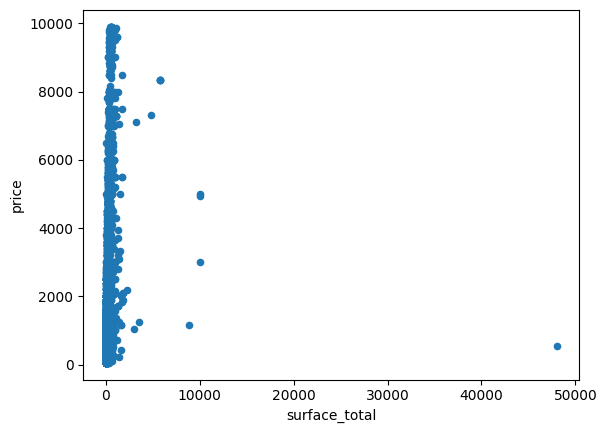

In [109]:
# Vamos a ver como se compara el precio de las propiedades con ciertas variables

# Precio por superficie
var = 'surface_total'
data = pd.concat([df_propiedades['price'], df_propiedades[var]], axis=1)
data.plot.scatter(x=var, y='price')

In [110]:
# Vemos algunos outliers, veamos la distribución de la variable
df_propiedades.surface_total.describe()

count     6537.000000
mean       159.575278
std        683.513602
min          0.000000
25%         45.000000
50%         70.000000
75%        155.730000
max      48000.000000
Name: surface_total, dtype: float64

In [111]:
# Vemos superficies con valor 0 y otras con espacios demasiado grandes, vamos a borrarlas
# Vamos a usar 10 metros cuadrados como minimo. 1000 metros cuadrados como máximo
print(df_propiedades.shape)
df_propiedades = df_propiedades.loc[df_propiedades.surface_total > 10]
df_propiedades = df_propiedades.loc[df_propiedades.surface_total < 1000]
print(df_propiedades.shape)
df_propiedades.surface_total.describe()

(6537, 118)
(6454, 118)


count    6454.000000
mean      129.309125
std       142.503473
min        12.000000
25%        45.000000
50%        70.000000
75%       150.000000
max       986.000000
Name: surface_total, dtype: float64

<Axes: xlabel='surface_total', ylabel='price'>

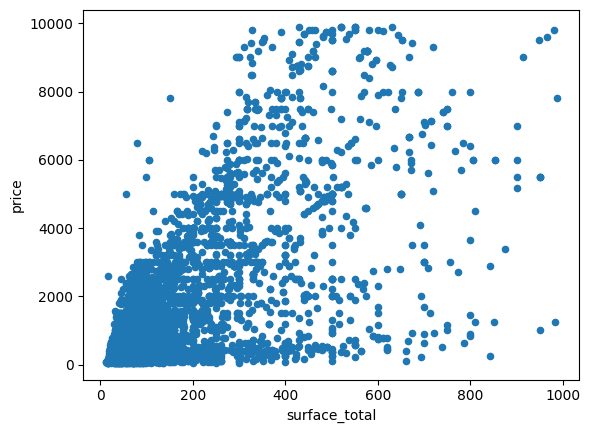

In [112]:
# Veamos la distribución ahora

# Precio por superficie
var = 'surface_total'
data = pd.concat([df_propiedades['price'], df_propiedades[var]], axis=1)
data.plot.scatter(x=var, y='price')

In [113]:
# Veamos como estan distribuidos los ambientes

# Vamos a borrar las entradas que no tienen información de ambientes
print(df_propiedades.shape)
df_propiedades = df_propiedades.loc[df_propiedades.ambience > 0]
df_propiedades = df_propiedades.loc[df_propiedades.ambience.notna()]
print(df_propiedades.shape)
df_propiedades.ambience.describe()

(6454, 118)
(4802, 118)


count    4802.000000
mean        2.541858
std         1.693936
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        25.000000
Name: ambience, dtype: float64

In [114]:
# Veamos como estan distribuidos los cuartos

df_propiedades.loc[(df_propiedades.bedrooms == 0) & (df_propiedades.ambience == 1), "bedrooms"] = 1
df_propiedades.loc[(df_propiedades.bedrooms.isna()) & (df_propiedades.ambience == 1), "bedrooms"] = 1

df_propiedades.loc[(df_propiedades.bedrooms == 0) & (df_propiedades.ambience == 2), "bedrooms"] = 1
df_propiedades.loc[(df_propiedades.bedrooms.isna()) & (df_propiedades.ambience == 2), "bedrooms"] = 1

# Vamos a borrar las entradas que no tienen información de cuartos
print(df_propiedades.shape)
df_propiedades = df_propiedades.loc[df_propiedades.bedrooms != 0]
df_propiedades = df_propiedades.loc[df_propiedades.bedrooms.notna()]
print(df_propiedades.shape)

df_propiedades.bedrooms.describe()

(4802, 118)
(4507, 118)


count    4507.000000
mean        1.544264
std         0.997769
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        19.000000
Name: bedrooms, dtype: float64

In [115]:
# Veamos como estan distribuidos los baños

# Vamos a rellenar los nulos con 1
df_propiedades['bathrooms'] = df_propiedades['bathrooms'].fillna(1)
df_propiedades.loc[(df_propiedades.bathrooms == 0), "bathrooms"] = 1

df_propiedades.bathrooms.describe()

count    4507.000000
mean        1.360994
std         0.758977
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        11.000000
Name: bathrooms, dtype: float64

In [116]:
# Hay algunas con antiguedad en None, las quitamos del dataset
df_propiedades = df_propiedades.loc[df_propiedades.antiquity.notna()]

In [117]:
df_propiedades = df_propiedades.drop(["description", "title"], axis=1)
df_propiedades.to_csv("meli_source.csv")

In [119]:
from pymongo.errors import DuplicateKeyError
# Insertamos la información en nuestra DB final en mongo

final_collection = db.PriceProduction

data_to_insert = df_propiedades.to_dict(orient="records")

for data in data_to_insert:
    try:
        final_collection.insert_one(data)
    # Esto significa que ya agregamos la propiedad antes, por lo que la actualizamos
    except DuplicateKeyError as e:
        target_id = data["_id"]
        res = final_collection.replace_one({"_id": target_id}, data)
